In [1]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import csv
import numpy as np
import time

# Hyperparameters
IMAGE_SIZE = (150,150)
EPOCHS = 100
BATCH_SIZE = 8
INITIAL_LEARNING_RATE = 1e-3


def image_gen_w_aug(train_parent_directory, validate_parent_directory, test_parent_directory):
    train_datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=30,
        zoom_range=0.2,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # we are only rescaling the test and validation sets
    test_datagen = ImageDataGenerator(rescale=1/255)
    val_datagen = ImageDataGenerator(rescale=1/255)

    train_generator = train_datagen.flow_from_directory(
        train_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        validate_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_parent_directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

def model_output():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
    model.add(MaxPooling2D(2, 2))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(BatchNormalization())

    # Flatten and Fully Connected Layers
    model.add(Flatten())
 
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(3, activation='softmax',kernel_regularizer=l2(0.001)))


    return model

train_dir = os.path.join('./datasets/train')
test_dir = os.path.join('./datasets/test')
val_dir = os.path.join('./datasets/validation')

train_generator, validation_generator, test_generator = image_gen_w_aug(train_dir, val_dir, test_dir)

model = model_output()
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Learning rate reduction
early_stop= EarlyStopping(monitor='val_loss',patience=7,verbose=1,start_from_epoch=40)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Start time
start_time = time.time()

model.summary()

with tf.device("/GPU:0"):
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        verbose=1,
        validation_data=validation_generator,
        callbacks=[lr_scheduler,early_stop]
    )


# end Time
end_time = time.time()
# duration 
duration = end_time - start_time

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

tf.keras.models.save_model(model,'my_model.h5')



2024-07-12 12:50:54.569921: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 12:50:54.582497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 12:50:54.600269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 12:50:54.600290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 12:50:54.612279: I tensorflow/core/platform/cpu_feature_gua

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-12 12:50:58.070072: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,003,651 (7.64 MB)

 Trainable params: 2,003,139 (7.64 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 212ms/step - accuracy: 0.3941 - loss: 1.6705 - val_accuracy: 0.4067 - val_loss: 1.3665 - learning_rate: 0.0010
Epoch 2/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.4919 - loss: 1.2782 - val_accuracy: 0.3333 - val_loss: 4.5028 - learning_rate: 0.0010
Epoch 3/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 64s 211ms/step - accuracy: 0.5695 - loss: 1.2290 - val_accuracy: 0.6400 - val_loss: 0.9892 - learning_rate: 0.0010
Epoch 4/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 66s 219ms/step - accuracy: 0.6571 - loss: 1.0511 - val_accuracy: 0.7600 - val_loss: 0.8981 - learning_rate: 0.0010
Epoch 5/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 79s 210ms/step - accuracy: 0.6832 - loss: 0.9233 - val_accuracy: 0.7267 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 6/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 213ms/step - accuracy: 0.7165 - loss: 0.8568 - val_accuracy: 0.7833 - val_loss: 0.7216 - learning_rate: 0.0010
Epoch 7/100
300/300 ━━━━━━━━━━━━━━━━━━━━ 81s 211ms/step - accuracy: 0.7289 -

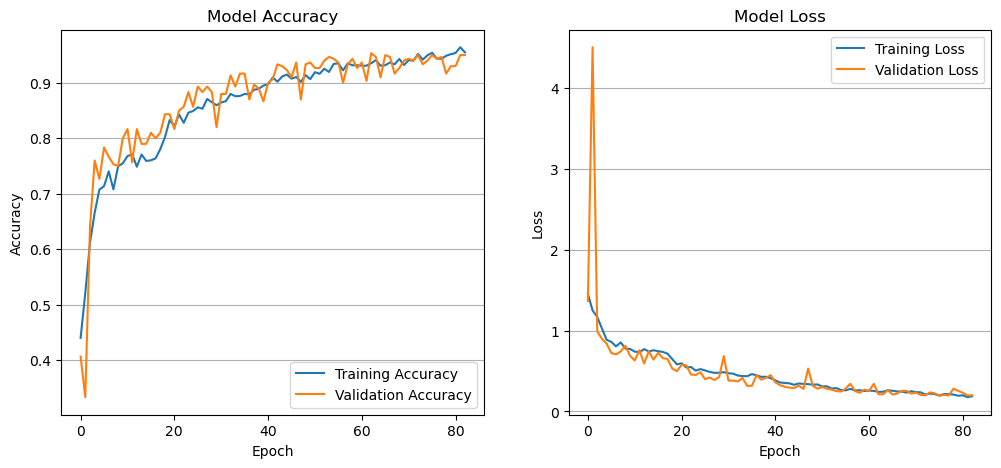

Total time taken to train the model: 99 minutes and 9 seconds

Final Training Accuracy: 0.9550
Final Validation Accuracy: 0.9500

Final Training Loss: 0.1884
Final Validation Loss: 0.1989

Test Accuracy: 96.67%
Test Loss: 0.1647


In [12]:

# Plot training and validation accuracy
plt.figure(figsize=(12,5))       
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Model Accuracy")
plt.grid(axis='y')
plt.legend()

# Plot training and validation loss
plt.subplot(122)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Model Loss")
plt.legend()
plt.grid(axis='y')
plt.show()

# Convert duration to minutes and seconds
duration_min, duration_sec = divmod(duration, 60)
print(f'Total time taken to train the model: {int(duration_min)} minutes and {int(duration_sec)} seconds')
print()
# Print out the final accuracy values
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print()
# Print out the final loss values
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')